## Certified privacy- and unlearning-safe training on the OCT-MNIST dataset

Run over different privacy and unlearning parameters and plot the results

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import math
import copy

import torch
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import abstract_gradient_training as agt
from abstract_gradient_training import AGTConfig
from abstract_gradient_training import certified_training_utils as ct_utils
from abstract_gradient_training import test_metrics
from models.deepmind import DeepMindSmall 
from datasets import oct_mnist

In [2]:
# set plotting options
sns.set_theme(context="poster", style="whitegrid", font_scale=1.7)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
palette = ["#DDC4DD", "#DCCFEC", "#A997DF", "#4F517D", "#1A3A3A"][::-1]
fontsize = "large"
results_dir = ".results/"
notebook_id = "oct_sweep_v1.2"
model_path = ".models/medmnist.ckpt"  # pretrained model path

### Define the nominal config, model and dataloaders

In [3]:
batchsize = 4000
nominal_config = AGTConfig(
    fragsize=500,
    learning_rate=0.3,
    n_epochs=1,
    forward_bound="interval",
    device="cuda:0",
    backward_bound="interval",
    loss="binary_cross_entropy",
    log_level="DEBUG",
    lr_decay=2.0,
    lr_min=0.001,
    early_stopping=False,
)

# get the "DeepMindSmall" model, pretrained on the MedMNIST dataset (without class 2, Drusen)
model = DeepMindSmall(1, 1)
model.load_state_dict(torch.load(model_path))
model = model.to(nominal_config.device)

# get dataloaders, train dataloader is a mix of drusen and the "healthy" class
dl_train, _ = oct_mnist.get_dataloaders(batchsize, 1000, exclude_classes=[0, 1], balanced=True)
_, dl_test_drusen = oct_mnist.get_dataloaders(batchsize, 1000, exclude_classes=[0, 1, 3])
_, dl_test_other = oct_mnist.get_dataloaders(batchsize, 1000, exclude_classes=[2])
_, dl_test_all = oct_mnist.get_dataloaders(batchsize, 1000)

[AGT] [WARNING ] [19:44:08] k=0 suffers from numerical instability, consider using dtype double or setting k > 0.


In [4]:
# compute pre-trained model accuracy
pretrain_acc = test_metrics.test_accuracy(
    *ct_utils.get_parameters(model), *next(iter(dl_test_drusen)), model, ct_utils.propagate_conv_layers
)[1]
pretrain_acc_all = test_metrics.test_accuracy(
    *ct_utils.get_parameters(model), *next(iter(dl_test_all)), model, ct_utils.propagate_conv_layers
)[1]
pretrain_acc_other = test_metrics.test_accuracy(
    *ct_utils.get_parameters(model), *next(iter(dl_test_other)), model, ct_utils.propagate_conv_layers
)[1]
print(f"Pre-trained accuracy on Drusen: {pretrain_acc:.3g}", file=sys.stderr)
print(f"Pre-trained accuracy on all classes:  {pretrain_acc_all:.3g}", file=sys.stderr)
print(f"Pre-trained accuracy on classes 0, 1, 3:  {pretrain_acc_other:.3g}", file=sys.stderr)

# perform one certified training run with to check the nominal accuracy we get
config = copy.deepcopy(nominal_config)
config.k_unlearn = 100
param_l, param_n, param_u = agt.unlearning_certified_training(
    model, config, dl_train, dl_test_drusen, transform=ct_utils.propagate_conv_layers
)
# compute the accuracies of the fine-tuned model
finetune_acc = test_metrics.test_accuracy(
    param_l, param_n, param_u, *next(iter(dl_test_drusen)), model, ct_utils.propagate_conv_layers
)[1]
finetune_acc_all = test_metrics.test_accuracy(
    param_l, param_n, param_u, *next(iter(dl_test_all)), model, ct_utils.propagate_conv_layers
)[1]
finetune_acc_other = test_metrics.test_accuracy(
    param_l, param_n, param_u, *next(iter(dl_test_other)), model, ct_utils.propagate_conv_layers
)[1]
print(f"Fine-tuned accuracy on Drusen: {finetune_acc:.3g}",file=sys.stderr)
print(f"Fine-tuned accuracy on all classes: {finetune_acc_all:.3g}",file=sys.stderr)
print(f"Fine-tuned accuracy on classes 0, 1, 3: {finetune_acc_other:.3g}", file=sys.stderr)

percent_certified = test_metrics.proportion_certified(
    param_n, param_l, param_u, *next(iter(dl_test_drusen)), model, ct_utils.propagate_conv_layers
)
print(f"Fine-tuned percent certified: {percent_certified:.3g}", file=sys.stderr)

del param_l, param_n, param_u
torch.cuda.empty_cache()

Pre-trained accuracy on Drusen: 0.58
Pre-trained accuracy on all classes:  0.86
Pre-trained accuracy on classes 0, 1, 3:  0.953
[AGT] [INFO    ] [19:44:13] =================== Starting Unlearning Certified Training ===================
[AGT] [DEBUG   ] [19:44:13] 	Privacy parameters: k_unlearn=100, clip_gamma=10000000000.0, dp_sgd_sigma=0
[AGT] [DEBUG   ] [19:44:13] 	Bounding methods: forward=interval, backward=interval
[AGT] [INFO    ] [19:44:13] Starting epoch 1
[AGT] [DEBUG   ] [19:44:13] Initialising dataloader batchsize to 4000
[AGT] [INFO    ] [19:44:13] Training batch 0: Network eval bounds=(0.58, 0.58, 0.58), W0 Bound=0.0 
[AGT] [INFO    ] [19:44:14] Training batch 1: Network eval bounds=(0.87, 0.94, 0.94), W0 Bound=0.296 
[AGT] [INFO    ] [19:44:15] Training batch 2: Network eval bounds=(0.78, 0.93, 0.96), W0 Bound=0.482 
[AGT] [DEBUG   ] [19:44:15] Skipping batch 3 in epoch 1 (expected size 4000, got 3508)
[AGT] [INFO    ] [19:44:15] Final network eval: Network eval bounds=(0.

### Helper functions to perform the sweep

In [5]:
def run_with_config(config):
    """If results for this configuration are already computed, load them from disk. Otherwise, run the certified
    training using AGT, then save and return the results."""
    fname = f"{results_dir}/{notebook_id}_{config.hash()}"
    if os.path.isfile(fname):  # run exists, so return the previous results
        param_l, param_n, param_u = torch.load(fname)
    else:
        # check whether the given config should be either unlearning or privacy training
        assert not (config.k_unlearn and config.k_private)
        if config.k_private:
            param_l, param_n, param_u = agt.privacy_certified_training(
                model, config, dl_train, dl_test_drusen, transform=ct_utils.propagate_conv_layers
            )
        else:
            param_l, param_n, param_u = agt.unlearning_certified_training(
                model, config, dl_train, dl_test_drusen, transform=ct_utils.propagate_conv_layers
            )
        torch.save((param_l, param_n, param_u), fname)
    # get nominal accuracy and percent certified (on the Drusen class)
    nominal_accuracy = test_metrics.test_accuracy(
        param_n, param_l, param_u, *next(iter(dl_test_drusen)), model, ct_utils.propagate_conv_layers
    )[1]
    percent_certified = test_metrics.proportion_certified(
        param_n, param_l, param_u, *next(iter(dl_test_drusen)), model, ct_utils.propagate_conv_layers
    )
    del param_l, param_n, param_u
    torch.cuda.empty_cache()
    return nominal_accuracy, percent_certified

### Perform the sweep over different gamma and k values

In [8]:
unlearning_results = {}  # the results dictionary will be indexed by results[gamma][k_private]
clip_gammas = [0.1, 0.2, 0.5, 1.0, math.inf]
k_unlearning_vals = list(range(0, 3000, 100)) + [2999]
config = copy.deepcopy(nominal_config)
for gamma in clip_gammas:
    config.clip_gamma = gamma
    tmp_results = {}
    for k_unlearn in k_unlearning_vals:
        config.k_unlearn = k_unlearn
        tmp_results[k_unlearn] = run_with_config(config)
    unlearning_results[gamma] = tmp_results

privacy_results = {}  # the results dictionary will be indexed by results[gamma][k_private]
k_private_vals = list(range(0, 1001, 30))
clip_gammas = [0.1, 0.2, 0.5, 1.0]

config = copy.deepcopy(nominal_config)
for gamma in clip_gammas:
    config.clip_gamma = gamma
    tmp_results = {}
    for k_private in k_private_vals:
        config.k_private = k_private
        tmp_results[k_private] = run_with_config(config)
    privacy_results[gamma] = tmp_results

### Plot the results

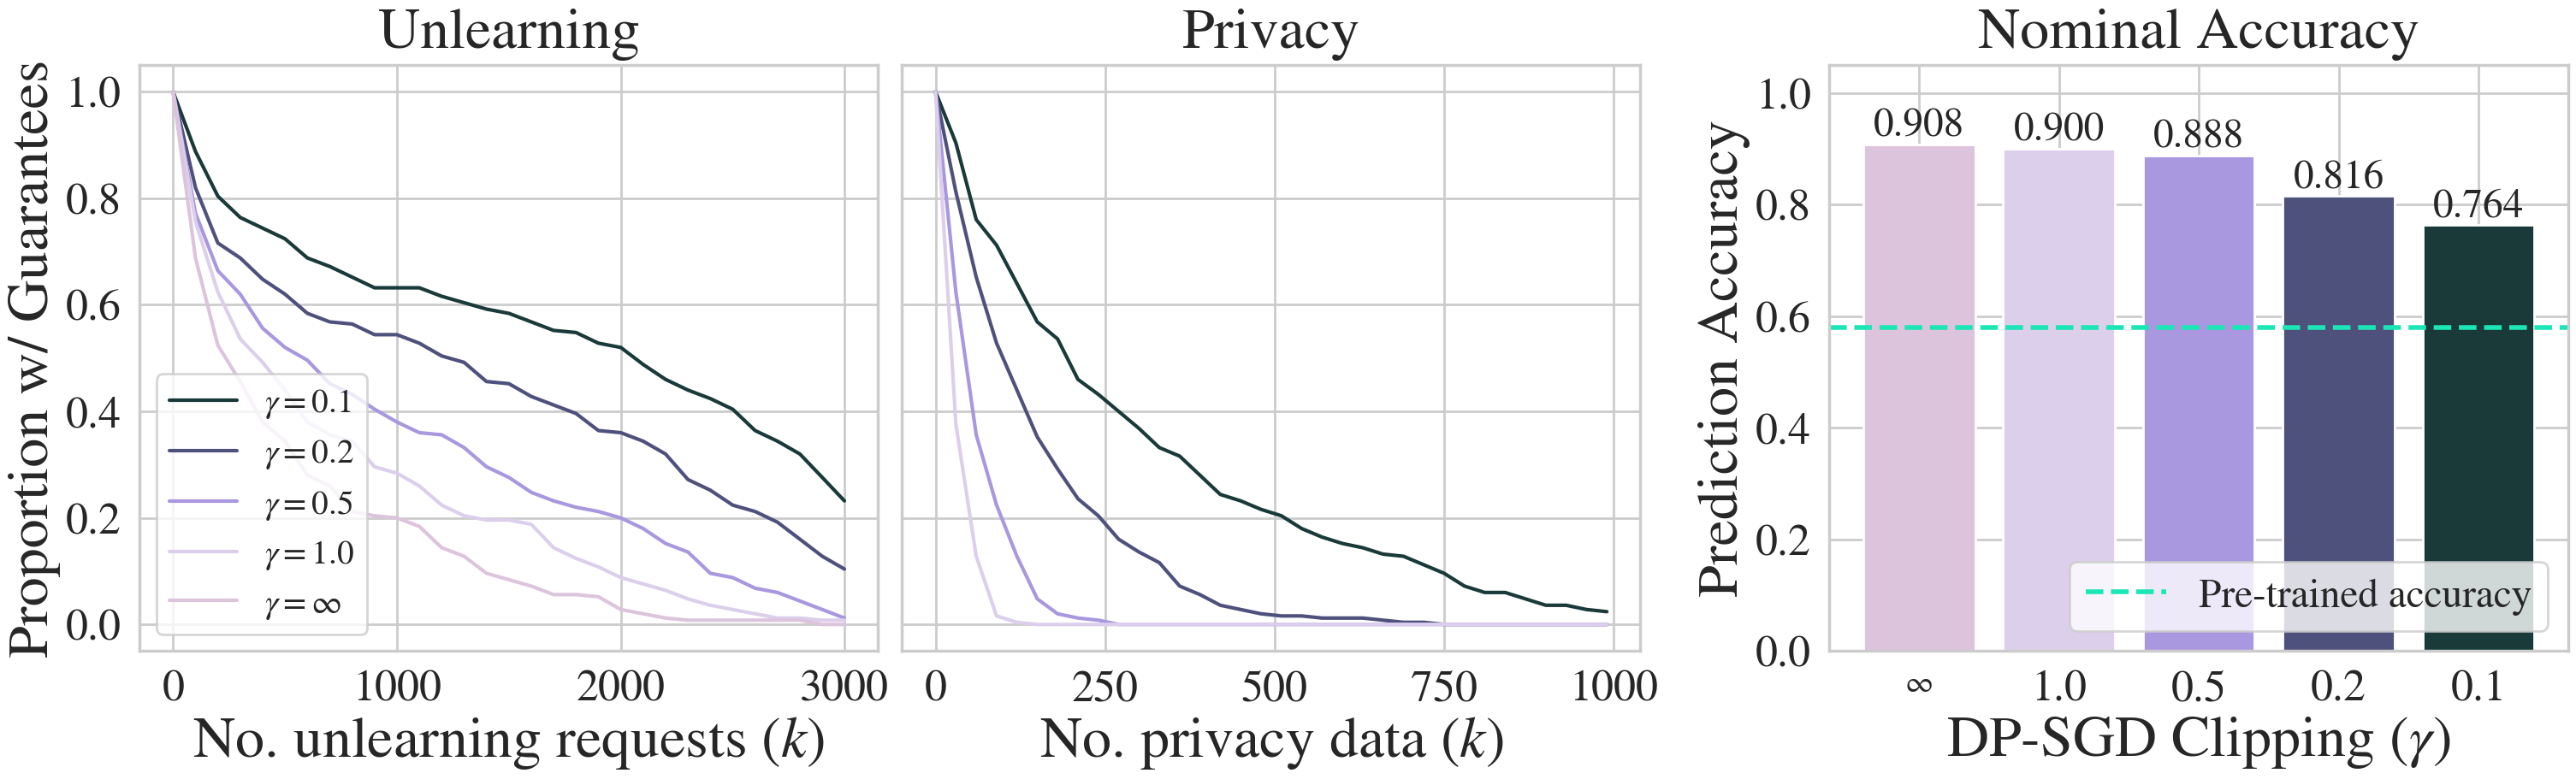

In [9]:
# Set up the figure, plus all the labels
fig, axs = plt.subplots(1, 4, figsize=(30, 9), layout="constrained", width_ratios=[2, 2, 0.04, 2])

# first plot the percent certified for unlearning on the first axis
colors = iter(palette)
for gamma, results in unlearning_results.items():
    k_unlearn_vals = list(results.keys())
    certified_percentages = [r[1] for r in results.values()]
    label = f"$\gamma = {gamma}$" if gamma != math.inf else "$\gamma = \infty$"
    axs[0].plot(k_unlearn_vals, certified_percentages, color=next(colors), label=label)
axs[0].set_ylabel("Proportion w/ Guarantees", fontsize=fontsize)
axs[0].set_xlabel("No. unlearning requests ($k$)", fontsize=fontsize)
axs[0].legend(loc="lower left", fontsize="x-small")
axs[0].set_title("Unlearning", fontsize=fontsize, pad=15)
axs[0].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
axs[0].set_ylim(-0.05, 1.05)

# then plot the percent certified for privacy on the second axis
colors = iter(palette)
for gamma, results in privacy_results.items():
    k_private_vals = list(results.keys())
    certified_percentages = [r[1] for r in results.values()]
    label = f"$\gamma = {gamma}$" if gamma != math.inf else "$\gamma = \infty$"
    axs[1].plot(k_private_vals, certified_percentages, color=next(colors), label=label)
axs[1].set_xlabel("No. privacy data ($k$)", fontsize=fontsize)
axs[1].set_title("Privacy", fontsize=fontsize, pad=15)
axs[1].set_yticklabels([])
axs[1].set_ylim(-0.05, 1.05)

# set the third axis to be invisible, its just used for spacing
axs[2].set_visible(False)

# plot the nominal accuracies on the fourth axis as a bar chart
bar_values = []
gamma_values = [str(g) if g != math.inf else "∞" for g in unlearning_results.keys()]
bar_colors = list(reversed(list(iter(palette))[: len(gamma_values)]))
for gamma, results in unlearning_results.items():
    nominal_accs = [r[0] for r in results.values()]
    bar_values.append(nominal_accs[0])
bars = axs[3].bar(gamma_values[::-1], bar_values[::-1], color=bar_colors)
axs[3].axhline(pretrain_acc, label="Pre-trained accuracy", color="#1be6b5", linestyle="--", lw=4)
axs[3].get_xticklabels()[0].set_fontsize(26)  # inf symbol too small
axs[3].set_ylabel("Prediction Accuracy", fontsize=fontsize)
axs[3].set_title("Nominal Accuracy", fontsize=fontsize, pad=15)
axs[3].legend(loc="lower right", fontsize="small")
axs[3].set_xlabel("DP-SGD Clipping ($\gamma$)", fontsize=fontsize)
axs[3].set_ylim(0.0, 1.05)

# Add height labels to each bar
for bar in bars:
    height = bar.get_height()
    axs[3].text(bar.get_x() + bar.get_width() / 2, height, f"{height:.3f}", ha="center", va="bottom", fontsize="small")